# Исследование объявлений о продаже квартир

В этом проекте мы исследуем  архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Определять рыночную стоимость объектов недвижимости.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Открываем файл с данными и изучаем информацию

In [43]:
import pandas as pd
import math
import re
import matplotlib.pyplot as plt 
import seaborn


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

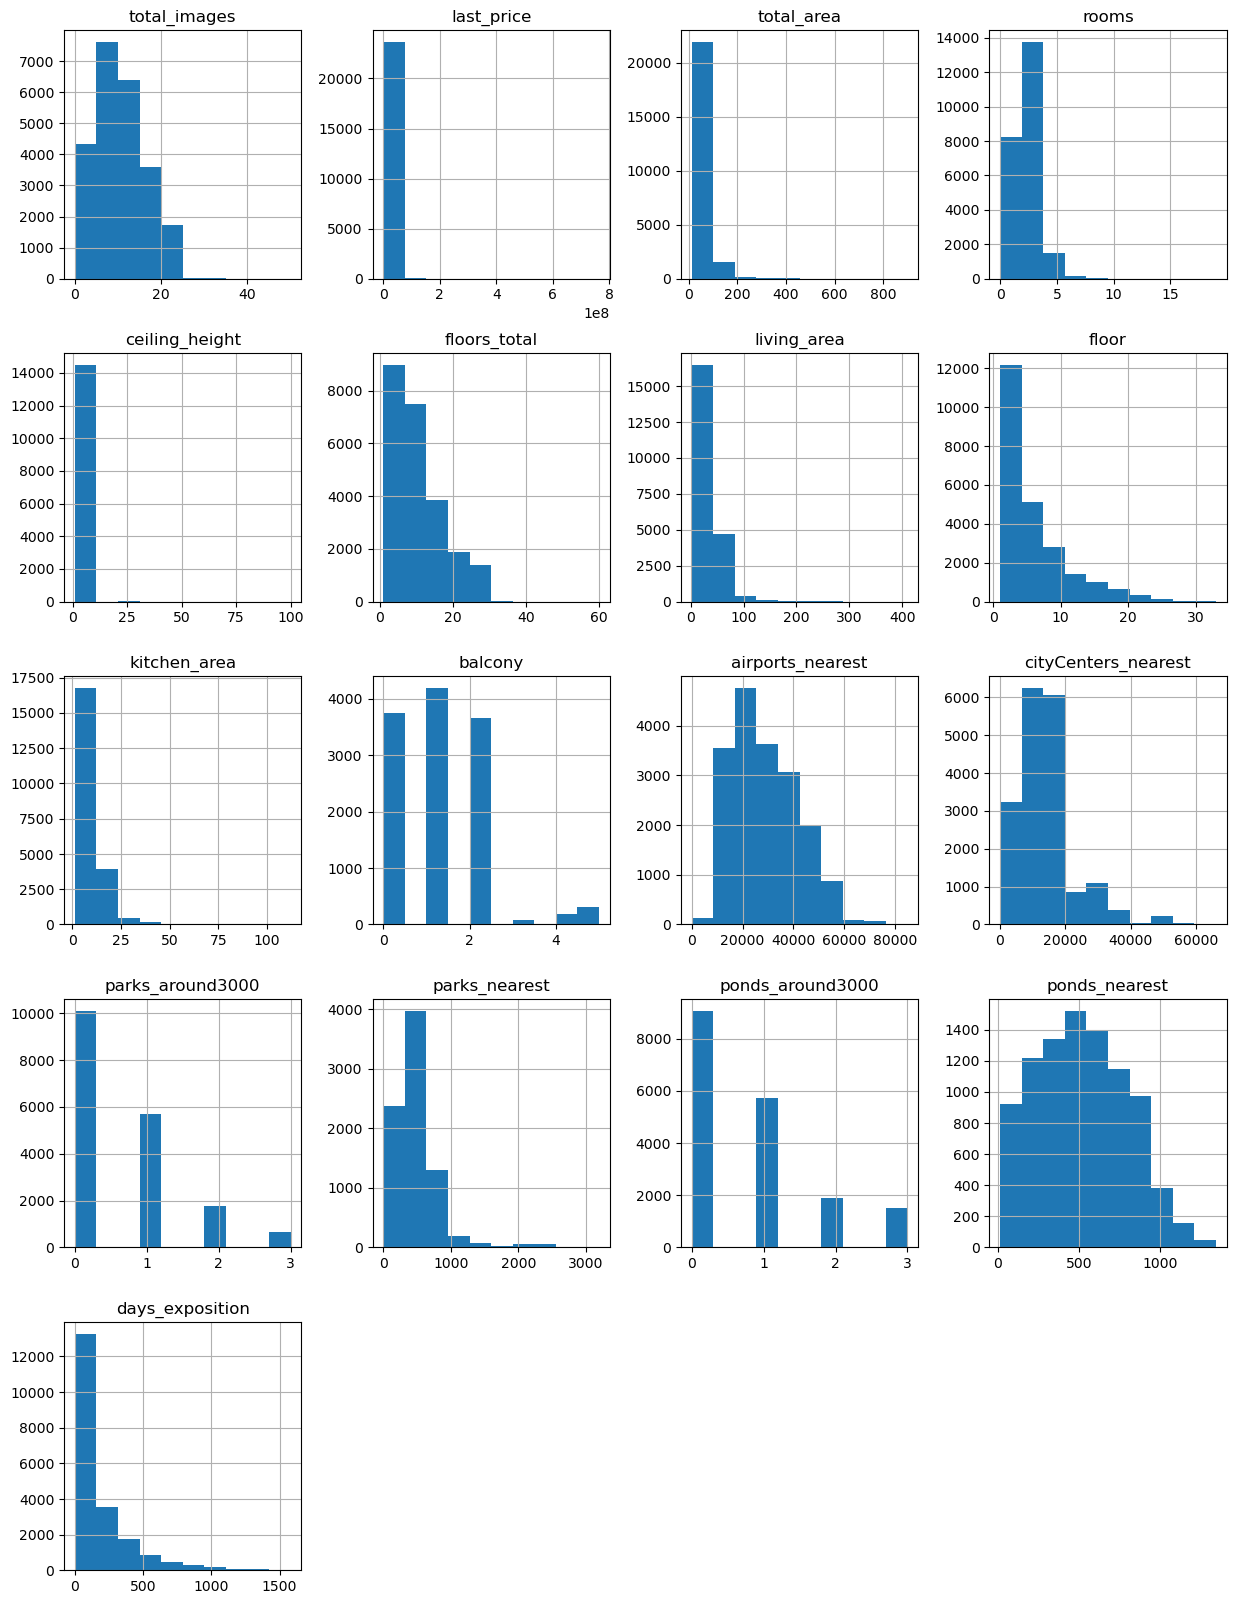

In [44]:
data = pd.read_csv('real_estate_data.csv', delimiter = '\t')
data.info()
data.hist(figsize=(15, 20));

In [155]:
pd.set_option('display.max_columns', None)
data.head(50)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,floor_type,cityCenters_nearest_km
1,7,3350000,40.0,2018-12-04,1,NaN,11,18.60,1,NaN,False,False,11.00,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,21.80,82921,1,12,2018,первый,19
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.30,4,NaN,False,False,8.30,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,21.70,92786,3,8,2015,другой,14
5,10,2890000,30.0,2018-09-10,1,NaN,12,14.40,5,NaN,False,False,9.10,0,поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,16.00,95066,0,9,2018,другой,0
6,6,3700000,37.0,2017-11-02,1,NaN,26,10.60,6,NaN,False,False,14.40,1,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,26.70,99196,3,11,2017,другой,19
7,5,7915000,72.0,2019-04-18,2,NaN,24,30.50,22,NaN,False,False,18.90,2,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,41.10,110545,3,4,2019,другой,12
8,20,2900000,33.0,2018-05-23,1,NaN,27,15.43,26,NaN,False,False,8.81,0,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,17.73,87455,2,5,2018,другой,0
9,18,5400000,61.0,2017-02-26,3,2.5,9,43.60,7,NaN,False,False,6.50,2,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,17.40,88525,6,2,2017,другой,15
10,5,5050000,40.0,2017-11-16,1,2.7,12,20.30,3,NaN,False,False,8.50,0,санкт-петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,19.30,127525,3,11,2017,другой,14
11,9,3300000,44.0,2018-08-27,2,NaN,5,31.00,4,False,False,False,6.00,1,ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0,13.00,75000,0,8,2018,другой,52
12,10,3890000,54.0,2016-06-30,2,NaN,5,30.00,5,NaN,False,False,9.00,0,сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0,24.00,72037,3,6,2016,последний,0


Ознакомившись с данными, можно сделать вывод о проблемах в них:
    <ol> 
			<li>Неверный тип данных. В столбце first_day_exposition нужно изменить тип данных на дату. В данных is_apartment нужно изменить тип данных на bool. Также,если это возможно, необходимо изменить формат для столбцов, где значения должно быть целыми числами.</li>
			<li> В некоторых столбцах присутствуют пропуски. Есть пропуски, которые мы заменим значением медианы, а обоснованные пропуски оставим без изменений.</li>
			<li>Категориальные данные locality_name имеют неявные дубликаты.</li>
    
Далее выполним предобработку данных
           

### Предобработка данных

Выводим кол-во пропущенных значений для каждых столбцов

In [156]:
data.isna().sum()

total_images                  0
last_price                    0
total_area                    0
first_day_exposition          0
rooms                         0
ceiling_height             8391
floors_total                  0
living_area                   0
floor                         0
is_apartment              18721
studio                        0
open_plan                     0
kitchen_area                  0
balcony                       0
locality_name                41
airports_nearest           5439
cityCenters_nearest        5428
parks_around3000           5427
parks_nearest             14674
ponds_around3000           5427
ponds_nearest             13627
days_exposition            2554
math_kitchen                  0
price_m2                      0
week_day                      0
month                         0
year                          0
floor_type                    0
cityCenters_nearest_km        0
dtype: int64

In [157]:
data.duplicated().sum()

0

In [158]:
data.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,cityCenters_nearest_km
total_images,1.000000,0.168271,0.111282,0.082864,0.012261,0.016199,0.091448,0.031077,-0.029228,-0.022136,-0.010417,0.047542,-0.004928,-0.034834,0.002607,-0.011746,-0.023811,0.003323,-0.037587,0.092362,0.122674,-0.008742,0.005556,0.147938,0.008932
last_price,0.168271,1.000000,0.679334,0.406625,0.379527,0.208404,0.516877,0.146011,-0.069438,-0.047516,0.352434,0.072000,-0.033818,-0.341844,0.107085,0.052197,0.142147,-0.052928,0.066325,0.625129,0.654188,-0.012905,0.003977,0.013516,0.121170
total_area,0.111282,0.679334,1.000000,0.797817,0.263680,-0.023649,0.888358,-0.029466,-0.123851,-0.075930,0.326615,0.066212,-0.014412,-0.109824,0.045823,0.008897,0.087676,-0.031223,0.100266,0.729355,-0.067444,-0.007221,0.006484,-0.050091,-0.006866
rooms,0.082864,0.406625,0.797817,1.000000,0.049857,-0.236861,0.898618,-0.181311,-0.175807,-0.109173,0.009691,0.001965,-0.041330,-0.058350,0.048205,-0.048053,0.014896,-0.006163,0.071328,0.299048,-0.229213,-0.000964,-0.004033,-0.026429,-0.003978
ceiling_height,0.012261,0.379527,0.263680,0.049857,1.000000,-0.006079,0.174376,-0.005067,0.036562,0.006795,0.236562,-0.051655,-0.085094,-0.256292,0.181818,-0.055387,0.183087,-0.091418,0.057841,0.285615,0.247333,-0.005574,0.005475,-0.069284,-0.116143
floors_total,0.016199,0.208404,-0.023649,-0.236861,-0.006079,1.000000,-0.187384,0.665950,0.069473,0.054749,0.219932,0.166901,0.093974,-0.031359,-0.237162,0.109966,-0.100272,0.024798,-0.040461,0.230842,0.337778,0.009153,0.014087,-0.000356,0.080826
living_area,0.091448,0.516877,0.888358,0.898618,0.174376,-0.187384,1.000000,-0.146160,-0.076357,-0.045593,0.056831,0.023668,-0.044869,-0.090494,0.073904,-0.045379,0.054242,-0.014746,0.078758,0.334060,-0.172643,-0.002781,-0.003041,-0.037300,-0.013264
floor,0.031077,0.146011,-0.029466,-0.181311,-0.005067,0.665950,-0.146160,1.000000,0.039101,0.039148,0.151491,0.161882,0.065288,-0.013121,-0.157029,0.083682,-0.063964,0.024976,-0.036963,0.157249,0.248956,0.010348,0.018813,0.000661,0.055656
studio,-0.029228,-0.069438,-0.123851,-0.175807,0.036562,0.069473,-0.076357,0.039101,1.000000,-0.004618,-0.026557,0.031761,-0.023724,-0.014805,-0.027736,0.010561,0.006504,-0.002025,-0.021920,-0.140300,0.047080,-0.001036,0.000355,0.011097,-0.025496
open_plan,-0.022136,-0.047516,-0.075930,-0.109173,0.006795,0.054749,-0.045593,0.039148,-0.004618,1.000000,-0.011051,0.037829,-0.014465,-0.005644,-0.010334,0.012668,0.010866,-0.004435,-0.023209,-0.087625,0.018962,0.011559,0.028970,-0.022922,-0.020743


1) Первые пропуски в данных находятся в столбце 'ceiling_height'- высота потолков (м). Это пропуски обоснованны, эту информацию клиенты могут не знать (в большинстве случаев) Для исследования эта информация не требуется и плюс этот параметр сложно с чем-то связать, чтобы найти медиану. Как вариант, вычислить дом по столбцу cityCenters_nearest и у совпадающих поставить одинаковую высоту потолков.

In [159]:
data['ceiling_height'].unique()

array([nan, 2.5, 2.7, 2.6, 3. , 2.8, 2.9, 3.2, 3.4, 4.2, 2.3, 3.1, 3.5,
       2. , 3.3, 2.4, 3.6, 3.8, 5. , 4.1, 3.7, 4. , 4.5, 8. , 4.4, 3.9,
       1.2, 8.3, 4.3, 5.3, 2.2, 1.4, 1.8, 4.7, 5.8, 1. ])

Заменяем аномальные значения столбца на нормальные.

In [160]:
data.loc[data['ceiling_height'] > 10,'ceiling_height'] = data['ceiling_height'] / 10

In [161]:
data['ceiling_height'].unique()

array([nan, 2.5, 2.7, 2.6, 3. , 2.8, 2.9, 3.2, 3.4, 4.2, 2.3, 3.1, 3.5,
       2. , 3.3, 2.4, 3.6, 3.8, 5. , 4.1, 3.7, 4. , 4.5, 8. , 4.4, 3.9,
       1.2, 8.3, 4.3, 5.3, 2.2, 1.4, 1.8, 4.7, 5.8, 1. ])

<b>2) floors_total</b>

Далее следую пропуски в столбце floors_total, как мы видим, тип данных float64. Посмотрим уникальные значения:

In [162]:
data['floors_total'].unique()

array([11,  5, 12, 26, 24, 27,  9,  6, 14, 17, 25,  3, 23, 16, 18,  4, 22,
       10,  7, 13, 19, 15,  2,  8,  0, 28, 36, 21, 20, 35, 34, 60,  1, 29,
       52, 37], dtype=int64)

In [163]:
data[data['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,floor_type,cityCenters_nearest_km


In [164]:
data[data.floors_total.isna()].describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,cityCenters_nearest_km
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
data[~data.floors_total.isna()].describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,cityCenters_nearest_km
count,21179.000000,2.117900e+04,21179.000000,21179.000000,12788.000000,21179.000000,21179.000000,21179.000000,21179.000000,21179.000000,15740.000000,15751.000000,15752.000000,6505.000000,15752.000000,7552.000000,18625.000000,21179.000000,21179.000000,21179.000000,21179.000000,21179.000000,21179.000000
mean,9.678172,4.753249e+06,51.881250,1.887719,2.685854,10.771283,29.657927,5.912649,10.451464,0.591954,28954.635832,15070.731636,0.551168,490.544197,0.704545,531.561573,170.990819,22.230933,92246.449880,2.576231,6.397375,2017.392417,11.204826
std,5.534166,2.141166e+06,16.670163,0.865303,0.246973,6.656487,12.096397,4.913245,5.664411,0.934983,13035.513532,8471.350355,0.759790,331.439128,0.886948,276.675939,209.310057,8.115528,29727.903493,1.795179,3.491147,1.017591,9.833527
min,0.000000,4.300000e+05,12.000000,0.000000,1.000000,0.000000,2.000000,1.000000,-24.785000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,16.000000,1.000000,-24.785000,7963.000000,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.300000e+06,39.000000,1.000000,2.500000,5.000000,18.000000,2.000000,7.000000,0.000000,17990.000000,10734.000000,0.000000,290.000000,0.000000,317.000000,43.000000,16.500000,74717.500000,1.000000,3.000000,2017.000000,0.000000
50%,9.000000,4.350000e+06,49.000000,2.000000,2.600000,9.000000,29.000000,4.000000,9.000000,0.000000,27245.500000,13679.000000,0.000000,456.000000,0.000000,520.000000,90.000000,21.000000,92857.000000,3.000000,6.000000,2017.000000,12.000000
75%,14.000000,5.900000e+06,62.000000,3.000000,2.800000,16.000000,38.300000,8.000000,11.760000,1.000000,37781.000000,16741.000000,1.000000,615.000000,1.000000,739.250000,216.000000,26.600000,109708.500000,4.000000,10.000000,2018.000000,16.000000
max,50.000000,1.199900e+07,100.000000,5.000000,8.300000,60.000000,91.785000,31.000000,78.900000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,79.000000,312240.000000,6.000000,12.000000,2019.000000,66.000000


In [166]:
data[data.floors_total.isna()].corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,cityCenters_nearest_km
total_images,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ceiling_height,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
floors_total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
living_area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
floor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
open_plan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
data[~data.floors_total.isna()].corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,cityCenters_nearest_km
total_images,1.000000,0.168271,0.111282,0.082864,0.012261,0.016199,0.091448,0.031077,-0.029228,-0.022136,-0.010417,0.047542,-0.004928,-0.034834,0.002607,-0.011746,-0.023811,0.003323,-0.037587,0.092362,0.122674,-0.008742,0.005556,0.147938,0.008932
last_price,0.168271,1.000000,0.679334,0.406625,0.379527,0.208404,0.516877,0.146011,-0.069438,-0.047516,0.352434,0.072000,-0.033818,-0.341844,0.107085,0.052197,0.142147,-0.052928,0.066325,0.625129,0.654188,-0.012905,0.003977,0.013516,0.121170
total_area,0.111282,0.679334,1.000000,0.797817,0.263680,-0.023649,0.888358,-0.029466,-0.123851,-0.075930,0.326615,0.066212,-0.014412,-0.109824,0.045823,0.008897,0.087676,-0.031223,0.100266,0.729355,-0.067444,-0.007221,0.006484,-0.050091,-0.006866
rooms,0.082864,0.406625,0.797817,1.000000,0.049857,-0.236861,0.898618,-0.181311,-0.175807,-0.109173,0.009691,0.001965,-0.041330,-0.058350,0.048205,-0.048053,0.014896,-0.006163,0.071328,0.299048,-0.229213,-0.000964,-0.004033,-0.026429,-0.003978
ceiling_height,0.012261,0.379527,0.263680,0.049857,1.000000,-0.006079,0.174376,-0.005067,0.036562,0.006795,0.236562,-0.051655,-0.085094,-0.256292,0.181818,-0.055387,0.183087,-0.091418,0.057841,0.285615,0.247333,-0.005574,0.005475,-0.069284,-0.116143
floors_total,0.016199,0.208404,-0.023649,-0.236861,-0.006079,1.000000,-0.187384,0.665950,0.069473,0.054749,0.219932,0.166901,0.093974,-0.031359,-0.237162,0.109966,-0.100272,0.024798,-0.040461,0.230842,0.337778,0.009153,0.014087,-0.000356,0.080826
living_area,0.091448,0.516877,0.888358,0.898618,0.174376,-0.187384,1.000000,-0.146160,-0.076357,-0.045593,0.056831,0.023668,-0.044869,-0.090494,0.073904,-0.045379,0.054242,-0.014746,0.078758,0.334060,-0.172643,-0.002781,-0.003041,-0.037300,-0.013264
floor,0.031077,0.146011,-0.029466,-0.181311,-0.005067,0.665950,-0.146160,1.000000,0.039101,0.039148,0.151491,0.161882,0.065288,-0.013121,-0.157029,0.083682,-0.063964,0.024976,-0.036963,0.157249,0.248956,0.010348,0.018813,0.000661,0.055656
studio,-0.029228,-0.069438,-0.123851,-0.175807,0.036562,0.069473,-0.076357,0.039101,1.000000,-0.004618,-0.026557,0.031761,-0.023724,-0.014805,-0.027736,0.010561,0.006504,-0.002025,-0.021920,-0.140300,0.047080,-0.001036,0.000355,0.011097,-0.025496
open_plan,-0.022136,-0.047516,-0.075930,-0.109173,0.006795,0.054749,-0.045593,0.039148,-0.004618,1.000000,-0.011051,0.037829,-0.014465,-0.005644,-0.010334,0.012668,0.010866,-0.004435,-0.023209,-0.087625,0.018962,0.011559,0.028970,-0.022922,-0.020743


Взаимосвязи или корреляции с другими данными нет.

Преобразуем в формат int

In [168]:
data['floors_total'] = data['floors_total'].fillna(0)

In [169]:
data['floors_total'].unique()

array([11,  5, 12, 26, 24, 27,  9,  6, 14, 17, 25,  3, 23, 16, 18,  4, 22,
       10,  7, 13, 19, 15,  2,  8,  0, 28, 36, 21, 20, 35, 34, 60,  1, 29,
       52, 37], dtype=int64)

In [170]:
data['floors_total'] = data['floors_total'].round().astype('int64')

<b>3) living_area </b>

In [171]:
data[~data.living_area.isna()].corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,cityCenters_nearest_km
total_images,1.000000,0.168271,0.111282,0.082864,0.012261,0.016199,0.091448,0.031077,-0.029228,-0.022136,-0.010417,0.047542,-0.004928,-0.034834,0.002607,-0.011746,-0.023811,0.003323,-0.037587,0.092362,0.122674,-0.008742,0.005556,0.147938,0.008932
last_price,0.168271,1.000000,0.679334,0.406625,0.379527,0.208404,0.516877,0.146011,-0.069438,-0.047516,0.352434,0.072000,-0.033818,-0.341844,0.107085,0.052197,0.142147,-0.052928,0.066325,0.625129,0.654188,-0.012905,0.003977,0.013516,0.121170
total_area,0.111282,0.679334,1.000000,0.797817,0.263680,-0.023649,0.888358,-0.029466,-0.123851,-0.075930,0.326615,0.066212,-0.014412,-0.109824,0.045823,0.008897,0.087676,-0.031223,0.100266,0.729355,-0.067444,-0.007221,0.006484,-0.050091,-0.006866
rooms,0.082864,0.406625,0.797817,1.000000,0.049857,-0.236861,0.898618,-0.181311,-0.175807,-0.109173,0.009691,0.001965,-0.041330,-0.058350,0.048205,-0.048053,0.014896,-0.006163,0.071328,0.299048,-0.229213,-0.000964,-0.004033,-0.026429,-0.003978
ceiling_height,0.012261,0.379527,0.263680,0.049857,1.000000,-0.006079,0.174376,-0.005067,0.036562,0.006795,0.236562,-0.051655,-0.085094,-0.256292,0.181818,-0.055387,0.183087,-0.091418,0.057841,0.285615,0.247333,-0.005574,0.005475,-0.069284,-0.116143
floors_total,0.016199,0.208404,-0.023649,-0.236861,-0.006079,1.000000,-0.187384,0.665950,0.069473,0.054749,0.219932,0.166901,0.093974,-0.031359,-0.237162,0.109966,-0.100272,0.024798,-0.040461,0.230842,0.337778,0.009153,0.014087,-0.000356,0.080826
living_area,0.091448,0.516877,0.888358,0.898618,0.174376,-0.187384,1.000000,-0.146160,-0.076357,-0.045593,0.056831,0.023668,-0.044869,-0.090494,0.073904,-0.045379,0.054242,-0.014746,0.078758,0.334060,-0.172643,-0.002781,-0.003041,-0.037300,-0.013264
floor,0.031077,0.146011,-0.029466,-0.181311,-0.005067,0.665950,-0.146160,1.000000,0.039101,0.039148,0.151491,0.161882,0.065288,-0.013121,-0.157029,0.083682,-0.063964,0.024976,-0.036963,0.157249,0.248956,0.010348,0.018813,0.000661,0.055656
studio,-0.029228,-0.069438,-0.123851,-0.175807,0.036562,0.069473,-0.076357,0.039101,1.000000,-0.004618,-0.026557,0.031761,-0.023724,-0.014805,-0.027736,0.010561,0.006504,-0.002025,-0.021920,-0.140300,0.047080,-0.001036,0.000355,0.011097,-0.025496
open_plan,-0.022136,-0.047516,-0.075930,-0.109173,0.006795,0.054749,-0.045593,0.039148,-0.004618,1.000000,-0.011051,0.037829,-0.014465,-0.005644,-0.010334,0.012668,0.010866,-0.004435,-0.023209,-0.087625,0.018962,0.011559,0.028970,-0.022922,-0.020743


Мы видим, что жилая площадь лучше всего коррелирует с общей площадью. Не смотря на корреляцию, логичнее в этом случае будет заменить значения в столбце медианными значениями из этого же столбца, группируя по комнатам. 

In [172]:
data.groupby('rooms').living_area.agg(['median','count'])

,median,count
rooms,,
0,18.0,195
1,17.6,8005
2,30.5,7593
3,44.0,4785
4,53.8,571
5,62.0,30


In [173]:
data['living_area'] = data['living_area'].fillna(data.groupby('rooms')['living_area'].transform("median"))

In [174]:
data['living_area'].isna().sum()

0

In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21179 entries, 1 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            21179 non-null  int64         
 1   last_price              21179 non-null  int64         
 2   total_area              21179 non-null  float64       
 3   first_day_exposition    21179 non-null  datetime64[ns]
 4   rooms                   21179 non-null  int64         
 5   ceiling_height          12788 non-null  float64       
 6   floors_total            21179 non-null  int64         
 7   living_area             21179 non-null  float64       
 8   floor                   21179 non-null  int64         
 9   is_apartment            2458 non-null   object        
 10  studio                  21179 non-null  bool          
 11  open_plan               21179 non-null  bool          
 12  kitchen_area            21179 non-null  float6

<b>is_apartment </b>

Сначала меняем тип данных с object на bull

In [176]:
data['is_apartment'].astype('bool')

1        True
2        True
5        True
6        True
7        True
         ... 
23693    True
23695    True
23696    True
23697    True
23698    True
Name: is_apartment, Length: 21179, dtype: bool

In [177]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [178]:
data.groupby('rooms')['is_apartment'].count()

rooms
0      6
1    918
2    898
3    564
4     66
5      6
Name: is_apartment, dtype: int64

Заменили тип данных и оставили пропуски как есть

<b>4) kitchen_area </b>

In [179]:
data['kitchen_area'].isna().sum()

0

In [180]:
data[~data.kitchen_area.isna()].corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,cityCenters_nearest_km
total_images,1.000000,0.168271,0.111282,0.082864,0.012261,0.016199,0.091448,0.031077,-0.029228,-0.022136,-0.010417,0.047542,-0.004928,-0.034834,0.002607,-0.011746,-0.023811,0.003323,-0.037587,0.092362,0.122674,-0.008742,0.005556,0.147938,0.008932
last_price,0.168271,1.000000,0.679334,0.406625,0.379527,0.208404,0.516877,0.146011,-0.069438,-0.047516,0.352434,0.072000,-0.033818,-0.341844,0.107085,0.052197,0.142147,-0.052928,0.066325,0.625129,0.654188,-0.012905,0.003977,0.013516,0.121170
total_area,0.111282,0.679334,1.000000,0.797817,0.263680,-0.023649,0.888358,-0.029466,-0.123851,-0.075930,0.326615,0.066212,-0.014412,-0.109824,0.045823,0.008897,0.087676,-0.031223,0.100266,0.729355,-0.067444,-0.007221,0.006484,-0.050091,-0.006866
rooms,0.082864,0.406625,0.797817,1.000000,0.049857,-0.236861,0.898618,-0.181311,-0.175807,-0.109173,0.009691,0.001965,-0.041330,-0.058350,0.048205,-0.048053,0.014896,-0.006163,0.071328,0.299048,-0.229213,-0.000964,-0.004033,-0.026429,-0.003978
ceiling_height,0.012261,0.379527,0.263680,0.049857,1.000000,-0.006079,0.174376,-0.005067,0.036562,0.006795,0.236562,-0.051655,-0.085094,-0.256292,0.181818,-0.055387,0.183087,-0.091418,0.057841,0.285615,0.247333,-0.005574,0.005475,-0.069284,-0.116143
floors_total,0.016199,0.208404,-0.023649,-0.236861,-0.006079,1.000000,-0.187384,0.665950,0.069473,0.054749,0.219932,0.166901,0.093974,-0.031359,-0.237162,0.109966,-0.100272,0.024798,-0.040461,0.230842,0.337778,0.009153,0.014087,-0.000356,0.080826
living_area,0.091448,0.516877,0.888358,0.898618,0.174376,-0.187384,1.000000,-0.146160,-0.076357,-0.045593,0.056831,0.023668,-0.044869,-0.090494,0.073904,-0.045379,0.054242,-0.014746,0.078758,0.334060,-0.172643,-0.002781,-0.003041,-0.037300,-0.013264
floor,0.031077,0.146011,-0.029466,-0.181311,-0.005067,0.665950,-0.146160,1.000000,0.039101,0.039148,0.151491,0.161882,0.065288,-0.013121,-0.157029,0.083682,-0.063964,0.024976,-0.036963,0.157249,0.248956,0.010348,0.018813,0.000661,0.055656
studio,-0.029228,-0.069438,-0.123851,-0.175807,0.036562,0.069473,-0.076357,0.039101,1.000000,-0.004618,-0.026557,0.031761,-0.023724,-0.014805,-0.027736,0.010561,0.006504,-0.002025,-0.021920,-0.140300,0.047080,-0.001036,0.000355,0.011097,-0.025496
open_plan,-0.022136,-0.047516,-0.075930,-0.109173,0.006795,0.054749,-0.045593,0.039148,-0.004618,1.000000,-0.011051,0.037829,-0.014465,-0.005644,-0.010334,0.012668,0.010866,-0.004435,-0.023209,-0.087625,0.018962,0.011559,0.028970,-0.022922,-0.020743


1 идея вычесть из общей площади все остальные и получить в недостоящих местах площадь кухни, посмотреть корреляцию этого нового столбца. 

In [181]:
data['math_kitchen'] = data['total_area'] - data['living_area']

In [182]:
data[~data.kitchen_area.isna()].corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,cityCenters_nearest_km
total_images,1.000000,0.168271,0.111282,0.082864,0.012261,0.016199,0.091448,0.031077,-0.029228,-0.022136,-0.010417,0.047542,-0.004928,-0.034834,0.002607,-0.011746,-0.023811,0.003323,-0.037587,0.092222,0.122674,-0.008742,0.005556,0.147938,0.008932
last_price,0.168271,1.000000,0.679334,0.406625,0.379527,0.208404,0.516877,0.146011,-0.069438,-0.047516,0.352434,0.072000,-0.033818,-0.341844,0.107085,0.052197,0.142147,-0.052928,0.066325,0.624616,0.654188,-0.012905,0.003977,0.013516,0.121170
total_area,0.111282,0.679334,1.000000,0.797817,0.263680,-0.023649,0.888358,-0.029466,-0.123851,-0.075930,0.326615,0.066212,-0.014412,-0.109824,0.045823,0.008897,0.087676,-0.031223,0.100266,0.729530,-0.067444,-0.007221,0.006484,-0.050091,-0.006866
rooms,0.082864,0.406625,0.797817,1.000000,0.049857,-0.236861,0.898618,-0.181311,-0.175807,-0.109173,0.009691,0.001965,-0.041330,-0.058350,0.048205,-0.048053,0.014896,-0.006163,0.071328,0.299201,-0.229213,-0.000964,-0.004033,-0.026429,-0.003978
ceiling_height,0.012261,0.379527,0.263680,0.049857,1.000000,-0.006079,0.174376,-0.005067,0.036562,0.006795,0.236562,-0.051655,-0.085094,-0.256292,0.181818,-0.055387,0.183087,-0.091418,0.057841,0.285602,0.247333,-0.005574,0.005475,-0.069284,-0.116143
floors_total,0.016199,0.208404,-0.023649,-0.236861,-0.006079,1.000000,-0.187384,0.665950,0.069473,0.054749,0.219932,0.166901,0.093974,-0.031359,-0.237162,0.109966,-0.100272,0.024798,-0.040461,0.230578,0.337778,0.009153,0.014087,-0.000356,0.080826
living_area,0.091448,0.516877,0.888358,0.898618,0.174376,-0.187384,1.000000,-0.146160,-0.076357,-0.045593,0.056831,0.023668,-0.044869,-0.090494,0.073904,-0.045379,0.054242,-0.014746,0.078758,0.334048,-0.172643,-0.002781,-0.003041,-0.037300,-0.013264
floor,0.031077,0.146011,-0.029466,-0.181311,-0.005067,0.665950,-0.146160,1.000000,0.039101,0.039148,0.151491,0.161882,0.065288,-0.013121,-0.157029,0.083682,-0.063964,0.024976,-0.036963,0.157231,0.248956,0.010348,0.018813,0.000661,0.055656
studio,-0.029228,-0.069438,-0.123851,-0.175807,0.036562,0.069473,-0.076357,0.039101,1.000000,-0.004618,-0.026557,0.031761,-0.023724,-0.014805,-0.027736,0.010561,0.006504,-0.002025,-0.021920,-0.140503,0.047080,-0.001036,0.000355,0.011097,-0.025496
open_plan,-0.022136,-0.047516,-0.075930,-0.109173,0.006795,0.054749,-0.045593,0.039148,-0.004618,1.000000,-0.011051,0.037829,-0.014465,-0.005644,-0.010334,0.012668,0.010866,-0.004435,-0.023209,-0.087956,0.018962,0.011559,0.028970,-0.022922,-0.020743


Мы видим, что новый столбец ближе всего. Заменим пропуски этими значениями

In [183]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['math_kitchen'])

In [184]:
data['kitchen_area'].isna().sum()

0

In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21179 entries, 1 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            21179 non-null  int64         
 1   last_price              21179 non-null  int64         
 2   total_area              21179 non-null  float64       
 3   first_day_exposition    21179 non-null  datetime64[ns]
 4   rooms                   21179 non-null  int64         
 5   ceiling_height          12788 non-null  float64       
 6   floors_total            21179 non-null  int64         
 7   living_area             21179 non-null  float64       
 8   floor                   21179 non-null  int64         
 9   is_apartment            2458 non-null   object        
 10  studio                  21179 non-null  bool          
 11  open_plan               21179 non-null  bool          
 12  kitchen_area            21179 non-null  float6

<b>5) balcony </b>

In [186]:
data['balcony'].isna().sum()

0

In [187]:
data['balcony'].unique()

array([2, 0, 1, 5, 4, 3], dtype=int64)

In [188]:
data[~data.balcony.isna()].corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,math_kitchen,price_m2,week_day,month,year,cityCenters_nearest_km
total_images,1.000000,0.168271,0.111282,0.082864,0.012261,0.016199,0.091448,0.031077,-0.029228,-0.022136,-0.010417,0.047542,-0.004928,-0.034834,0.002607,-0.011746,-0.023811,0.003323,-0.037587,0.092222,0.122674,-0.008742,0.005556,0.147938,0.008932
last_price,0.168271,1.000000,0.679334,0.406625,0.379527,0.208404,0.516877,0.146011,-0.069438,-0.047516,0.352434,0.072000,-0.033818,-0.341844,0.107085,0.052197,0.142147,-0.052928,0.066325,0.624616,0.654188,-0.012905,0.003977,0.013516,0.121170
total_area,0.111282,0.679334,1.000000,0.797817,0.263680,-0.023649,0.888358,-0.029466,-0.123851,-0.075930,0.326615,0.066212,-0.014412,-0.109824,0.045823,0.008897,0.087676,-0.031223,0.100266,0.729530,-0.067444,-0.007221,0.006484,-0.050091,-0.006866
rooms,0.082864,0.406625,0.797817,1.000000,0.049857,-0.236861,0.898618,-0.181311,-0.175807,-0.109173,0.009691,0.001965,-0.041330,-0.058350,0.048205,-0.048053,0.014896,-0.006163,0.071328,0.299201,-0.229213,-0.000964,-0.004033,-0.026429,-0.003978
ceiling_height,0.012261,0.379527,0.263680,0.049857,1.000000,-0.006079,0.174376,-0.005067,0.036562,0.006795,0.236562,-0.051655,-0.085094,-0.256292,0.181818,-0.055387,0.183087,-0.091418,0.057841,0.285602,0.247333,-0.005574,0.005475,-0.069284,-0.116143
floors_total,0.016199,0.208404,-0.023649,-0.236861,-0.006079,1.000000,-0.187384,0.665950,0.069473,0.054749,0.219932,0.166901,0.093974,-0.031359,-0.237162,0.109966,-0.100272,0.024798,-0.040461,0.230578,0.337778,0.009153,0.014087,-0.000356,0.080826
living_area,0.091448,0.516877,0.888358,0.898618,0.174376,-0.187384,1.000000,-0.146160,-0.076357,-0.045593,0.056831,0.023668,-0.044869,-0.090494,0.073904,-0.045379,0.054242,-0.014746,0.078758,0.334048,-0.172643,-0.002781,-0.003041,-0.037300,-0.013264
floor,0.031077,0.146011,-0.029466,-0.181311,-0.005067,0.665950,-0.146160,1.000000,0.039101,0.039148,0.151491,0.161882,0.065288,-0.013121,-0.157029,0.083682,-0.063964,0.024976,-0.036963,0.157231,0.248956,0.010348,0.018813,0.000661,0.055656
studio,-0.029228,-0.069438,-0.123851,-0.175807,0.036562,0.069473,-0.076357,0.039101,1.000000,-0.004618,-0.026557,0.031761,-0.023724,-0.014805,-0.027736,0.010561,0.006504,-0.002025,-0.021920,-0.140503,0.047080,-0.001036,0.000355,0.011097,-0.025496
open_plan,-0.022136,-0.047516,-0.075930,-0.109173,0.006795,0.054749,-0.045593,0.039148,-0.004618,1.000000,-0.011051,0.037829,-0.014465,-0.005644,-0.010334,0.012668,0.010866,-0.004435,-0.023209,-0.087956,0.018962,0.011559,0.028970,-0.022922,-0.020743


Заменим Nan, на 0 балконов

In [189]:
data['balcony'] = data['balcony'].fillna(0)

In [190]:
data['balcony'].unique()

array([2, 0, 1, 5, 4, 3], dtype=int64)

Меняем тип данных на int, так как балконы это целое число, в отличии от площади

In [191]:
data['balcony'] = data['balcony'].round().astype('int64')

<b>6) locality_name  </b>

In [192]:
data['locality_name'].isna().sum()

41

In [193]:
data['locality_name'].value_counts()

санкт-петербург                               13390
поселок мурино                                  556
поселок шушары                                  431
всеволожск                                      390
пушкин                                          333
                                              ...  
поселок при железнодорожной станции вещево        1
деревня щеглово                                   1
поселок белоостров                                1
деревня пельгора                                  1
поселок дзержинского                              1
Name: locality_name, Length: 320, dtype: int64

In [194]:
data['locality_name'] = data['locality_name'].str.lower()


In [195]:
data_sorted = data.sort_values(by='locality_name')
data_sorted['locality_name'].unique()

array(['бокситогорск', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'высоцк', 'гатчина', 'деревня агалатово', 'деревня аро',
       'деревня батово', 'деревня бегуницы', 'деревня белогорка',
       'деревня большая вруда', 'деревня большая пустомержа',
       'деревня большие колпаны', 'деревня большое рейзино',
       'деревня большой сабск', 'деревня бор', 'деревня борисова грива',
       'деревня ваганово', 'деревня вартемяги', 'деревня вахнова кара',
       'деревня выскатка', 'деревня гарболово', 'деревня глинка',
       'деревня горбунки', 'деревня гостилицы', 'деревня заклинье',
       'деревня заневка', 'деревня зимитицы', 'деревня извара',
       'деревня иссад', 'деревня калитино', 'деревня кальтино',
       'деревня камышовка', 'деревня келози', 'деревня кипень',
       'деревня кисельня', 'деревня колтуши', 'деревня коркино',
       'деревня котлы', 'деревня кривко', 'деревня кудрово',
       'деревня кузьмолово', 'деревня курковицы', 'деревня куровицы',
       'дер

Мы видим много повторяющихся значений из-за е и ё. Заменим все ё на е

In [196]:
data['locality_name'] = data['locality_name'].str.replace('ё','е')

Далее мы видим, что городской поселок и поселок городского типа дублируют себя и по сути, являются одним тем же. Земеним городской поселок на поселок городского типа

In [197]:
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')

In [198]:
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','поселок')

In [199]:
data.groupby('locality_name')['locality_name'].count() 


locality_name
бокситогорск     16
волосово         36
волхов          111
всеволожск      390
выборг          222
               ... 
сосновый бор     85
сясьстрой        24
тихвин           49
тосно           102
шлиссельбург     56
Name: locality_name, Length: 320, dtype: int64

In [200]:
data_sorted = data.sort_values(by='locality_name')
data_sorted['locality_name'].unique()

array(['бокситогорск', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'высоцк', 'гатчина', 'деревня агалатово', 'деревня аро',
       'деревня батово', 'деревня бегуницы', 'деревня белогорка',
       'деревня большая вруда', 'деревня большая пустомержа',
       'деревня большие колпаны', 'деревня большое рейзино',
       'деревня большой сабск', 'деревня бор', 'деревня борисова грива',
       'деревня ваганово', 'деревня вартемяги', 'деревня вахнова кара',
       'деревня выскатка', 'деревня гарболово', 'деревня глинка',
       'деревня горбунки', 'деревня гостилицы', 'деревня заклинье',
       'деревня заневка', 'деревня зимитицы', 'деревня извара',
       'деревня иссад', 'деревня калитино', 'деревня кальтино',
       'деревня камышовка', 'деревня келози', 'деревня кипень',
       'деревня кисельня', 'деревня колтуши', 'деревня коркино',
       'деревня котлы', 'деревня кривко', 'деревня кудрово',
       'деревня кузьмолово', 'деревня курковицы', 'деревня куровицы',
       'дер

Убрали 41 дубликат

<b>6) airports_nearest, cityCenters_nearest  </b>

Расстояние до ближайшего аэропорта в метрах. Мы не можем заполнить пропуски? так как расстояние это точная величина, мы не можем ее предсказать.

In [201]:
data.isna().sum()

total_images                  0
last_price                    0
total_area                    0
first_day_exposition          0
rooms                         0
ceiling_height             8391
floors_total                  0
living_area                   0
floor                         0
is_apartment              18721
studio                        0
open_plan                     0
kitchen_area                  0
balcony                       0
locality_name                41
airports_nearest           5439
cityCenters_nearest        5428
parks_around3000           5427
parks_nearest             14674
ponds_around3000           5427
ponds_nearest             13627
days_exposition            2554
math_kitchen                  0
price_m2                      0
week_day                      0
month                         0
year                          0
floor_type                    0
cityCenters_nearest_km        0
dtype: int64

In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21179 entries, 1 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            21179 non-null  int64         
 1   last_price              21179 non-null  int64         
 2   total_area              21179 non-null  float64       
 3   first_day_exposition    21179 non-null  datetime64[ns]
 4   rooms                   21179 non-null  int64         
 5   ceiling_height          12788 non-null  float64       
 6   floors_total            21179 non-null  int64         
 7   living_area             21179 non-null  float64       
 8   floor                   21179 non-null  int64         
 9   is_apartment            2458 non-null   object        
 10  studio                  21179 non-null  bool          
 11  open_plan               21179 non-null  bool          
 12  kitchen_area            21179 non-null  float6

<b>7) first_day_exposition </b>

Превращаем содержимое столбца в понятные для Phython даты

In [203]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

<b>8) last_price </b>

Меняем тип данных на int

In [204]:
data['last_price'] = data['last_price'].round().astype('int64')

In [205]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21179 entries, 1 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            21179 non-null  int64         
 1   last_price              21179 non-null  int64         
 2   total_area              21179 non-null  float64       
 3   first_day_exposition    21179 non-null  datetime64[ns]
 4   rooms                   21179 non-null  int64         
 5   ceiling_height          12788 non-null  float64       
 6   floors_total            21179 non-null  int64         
 7   living_area             21179 non-null  float64       
 8   floor                   21179 non-null  int64         
 9   is_apartment            2458 non-null   object        
 10  studio                  21179 non-null  bool          
 11  open_plan               21179 non-null  bool          
 12  kitchen_area            21179 non-null  float6

<strong>Поиск аномальных значений</strong>

1) last_price

Для чистоты анализа изучим данные last_price, и постараемся определить в них аномальные значения.

Построим диаграмму размаха и определим выбросы:

(0.0, 14000000.0)

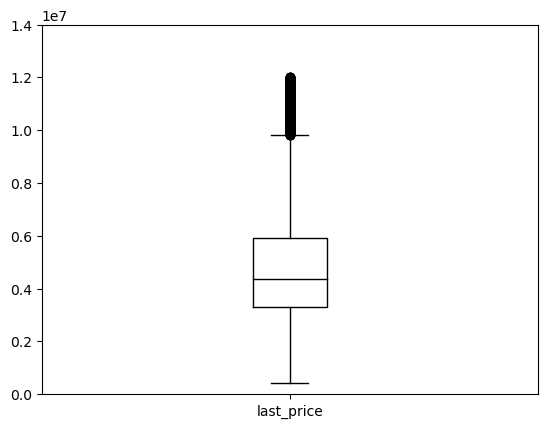

In [206]:
data.boxplot(column=['last_price'], grid= False , color='black')
plt.ylim(0,14000000)

Мы видим, что объявления с ценой квартиры выше 12млн являются выбросами. Посмотрим, какое кол-во объявлений входит в эту группу:

In [207]:
data[data['last_price'] > 12000000]['last_price'].count()

0

1941 значение меньше допустимых 10%. Далее удалим строки с выбросами:

In [208]:
data = data[data['last_price'] < 12000000]

2) rooms

(1.0, 10.0)

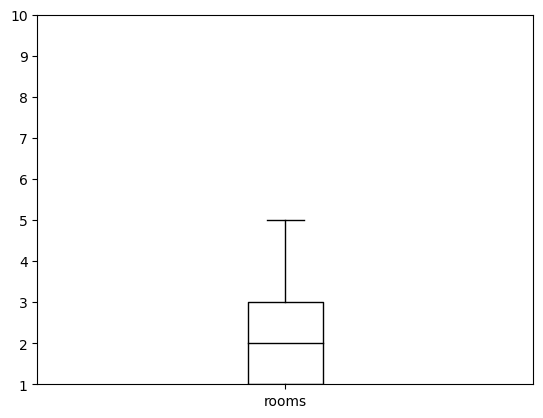

In [209]:
data.boxplot(column=['rooms'], grid= False , color='black')
plt.ylim(1,10)

Диаграмма показывает, что кол-во комнат больше 6 - это выбросы в данных

In [210]:
data[data['rooms'] >= 6]['rooms'].count()

0

In [211]:
data = data[data['rooms'] < 6]

3) total_area 

(1.0, 100.0)

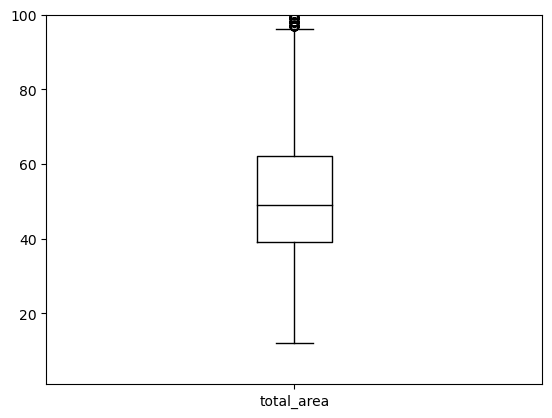

In [212]:
data.boxplot(column=['total_area'], grid= False , color='black')
plt.ylim(1,100)

Объявления с заявленной общей площадью больше 100м, являются выбросами. Посчитаем кол-во таких объявлений:

In [213]:
data[data['total_area'] > 100]['total_area'].count()

0

In [214]:
data = data[data['total_area'] < 100]

In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21174 entries, 1 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            21174 non-null  int64         
 1   last_price              21174 non-null  int64         
 2   total_area              21174 non-null  float64       
 3   first_day_exposition    21174 non-null  datetime64[ns]
 4   rooms                   21174 non-null  int64         
 5   ceiling_height          12783 non-null  float64       
 6   floors_total            21174 non-null  int64         
 7   living_area             21174 non-null  float64       
 8   floor                   21174 non-null  int64         
 9   is_apartment            2458 non-null   object        
 10  studio                  21174 non-null  bool          
 11  open_plan               21174 non-null  bool          
 12  kitchen_area            21174 non-null  float6

### Посчитаем и добавим в таблицу новые столбцы

1)цена одного квадратного метра

In [216]:
data['price_m2'] = (data['last_price'] / data['total_area']).round().astype('int64')

    2)день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
    3)месяц публикации объявления
    4)год публикации объявления

In [217]:
data['week_day'] = data['first_day_exposition'].dt.weekday

In [218]:
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

In [219]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

5)тип этажа квартиры (значения — «‎первый», «последний», «другой»)

In [220]:
data['floors_total'].unique()

array([11,  5, 12, 26, 24, 27,  9,  6, 14, 17, 25,  3, 23, 16, 18,  4, 22,
       10,  7, 13, 19, 15,  2,  8,  0, 28, 36, 21, 20, 35, 34, 60,  1, 29,
       52, 37], dtype=int64)

In [221]:
def floor_type(data):
    if data['floor'] == 1:
        return 'первый'
    elif data['floor'] == data['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type,axis=1)

6)расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [222]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()

### Исследовательский анализ данных

1) total_area

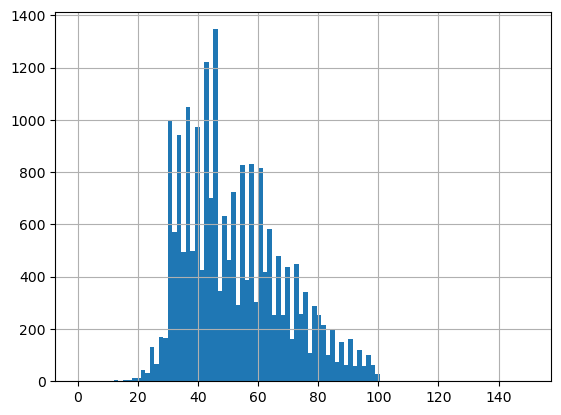

In [223]:
data['total_area'].hist(bins = 100, range = (0, 150));

In [224]:
data['total_area'].describe()

count    21174.000000
mean        51.869888
std         16.655721
min         12.000000
25%         39.000000
50%         49.000000
75%         62.000000
max         99.000000
Name: total_area, dtype: float64

2) living_area

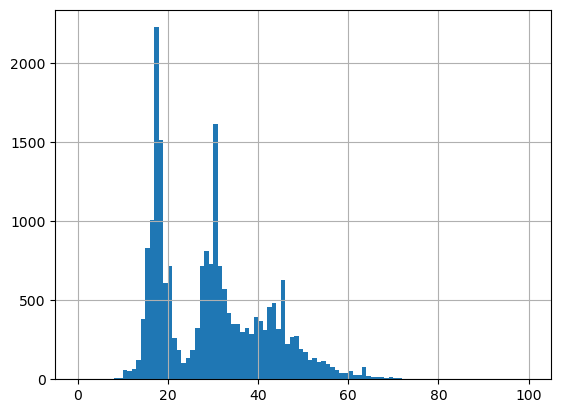

In [225]:
data['living_area'].hist(bins = 100, range = (0, 100));

In [226]:
data['living_area'].describe()

count    21174.000000
mean        29.651177
std         12.089134
min          2.000000
25%         18.000000
50%         29.000000
75%         38.300000
max         91.785000
Name: living_area, dtype: float64

3)kitchen_area 

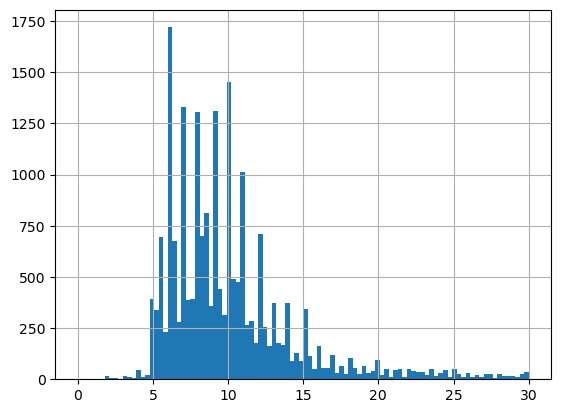

In [227]:
data['kitchen_area'].hist(bins = 100, range = (0, 30));

In [228]:
data['kitchen_area'].describe()

count    21174.000000
mean        10.448921
std          5.656516
min        -24.785000
25%          7.000000
50%          9.000000
75%         11.725000
max         78.900000
Name: kitchen_area, dtype: float64

4) last_price

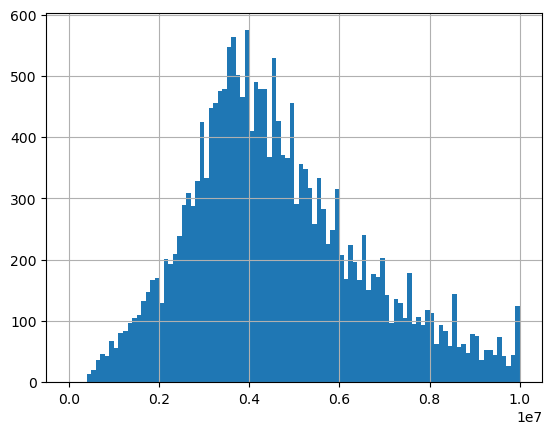

In [229]:
data['last_price'].hist(bins = 100, range = (0, 10000000));

In [230]:
data['last_price'].describe()/1000000

count     0.021174
mean      4.752013
std       2.139866
min       0.430000
25%       3.300000
50%       4.350000
75%       5.900000
max      11.999000
Name: last_price, dtype: float64

Больше всего объявлений в диапозоне от 2 до 6 миллионов

5) rooms 

In [231]:
data['rooms'].unique()

array([1, 2, 3, 4, 0, 5], dtype=int64)

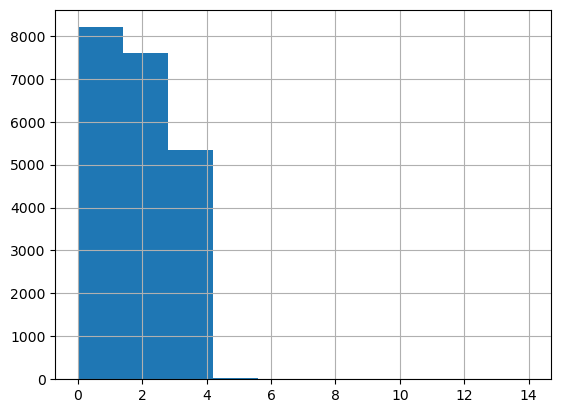

In [232]:
data['rooms'].hist(bins = 10, range = (0, 14));

Больше всего однокомнатных и двухкомнатных квартир продаются

6) ceiling_height 

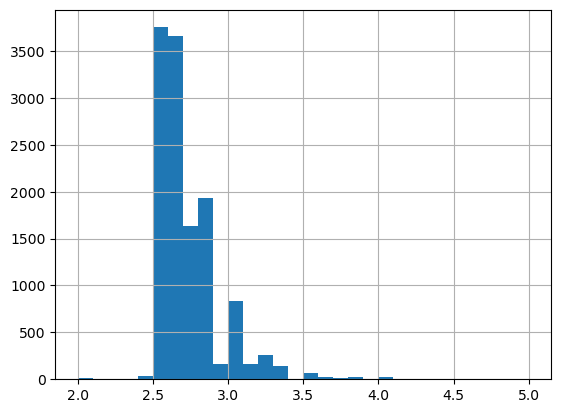

In [233]:
data['ceiling_height'].hist(bins = 30, range = (2, 5));

В большинстве объявлений высота потолка варьируется в диапозоне от 2.5 до 3 м. 

7) floor

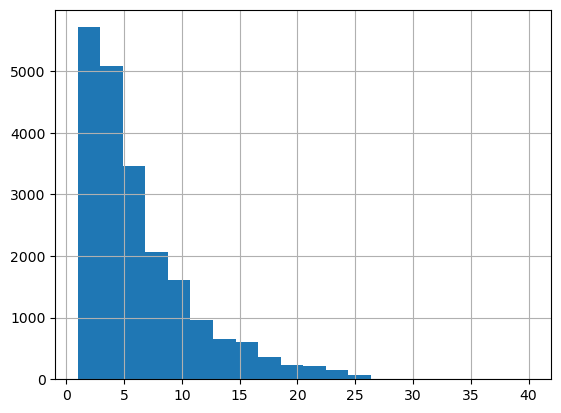

In [234]:
data['floor'].hist(bins = 20, range = (1,40));

Чаще всего продают квартиры на этажах с 1 по 5

8) floor_type

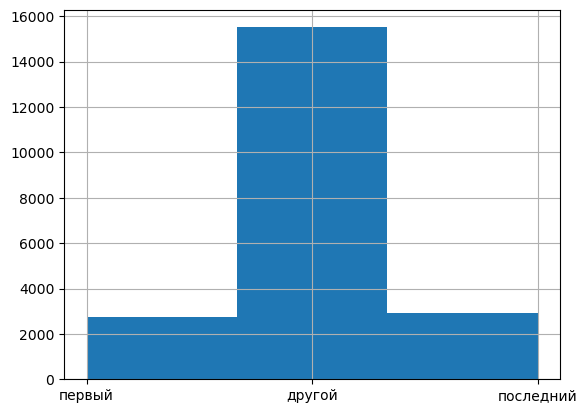

In [235]:
data['floor_type'].hist(bins = 3);

Последний этаж продается также часто, как и первый

7) floors_total

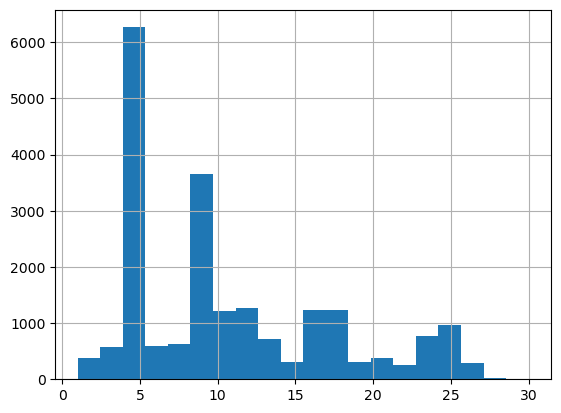

In [236]:
data['floors_total'].hist(bins = 20, range = (1,30));

Можем здесь выделить 5ти этажные дома и 9ти этажные, в которых квартиры продаются чаще всего.

8) cityCenters_nearest

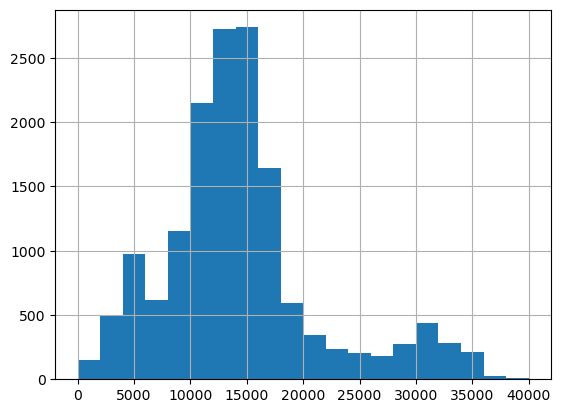

In [237]:
data['cityCenters_nearest'].hist(bins = 20, range = (1,40000));

Больше всего объявлений на расстоянии 10 - 18 км.

9) airports_nearest 

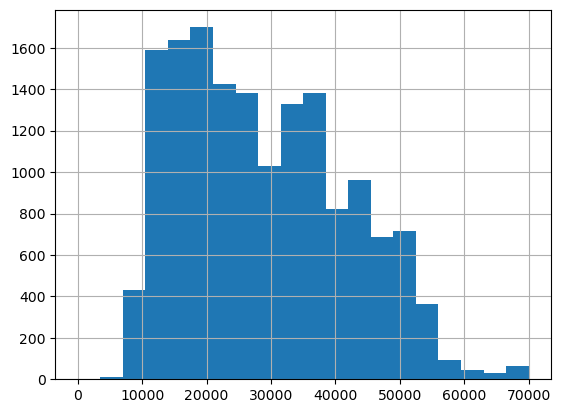

In [238]:
data['airports_nearest'].hist(bins = 20, range = (1,70000));

In [239]:
data['airports_nearest'].describe()

count    15735.000000
mean     28954.471306
std      13035.582564
min          0.000000
25%      17989.000000
50%      27250.000000
75%      37781.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Расстояние до аэропорта в среднем составляет 28 км. 

10) parks_nearest 

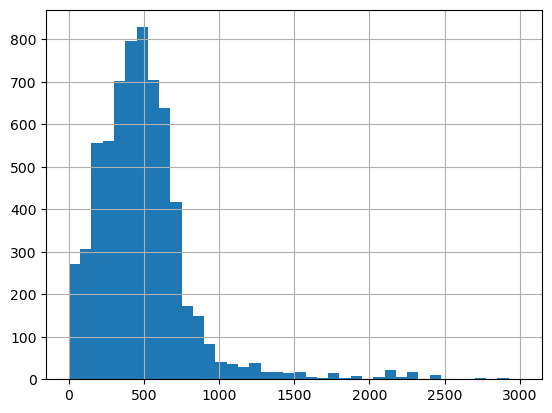

In [240]:
data['parks_nearest'].hist(bins = 40, range = (1,3000));

Для большинства объявлений парк находится в километровой доступности

11) week_day

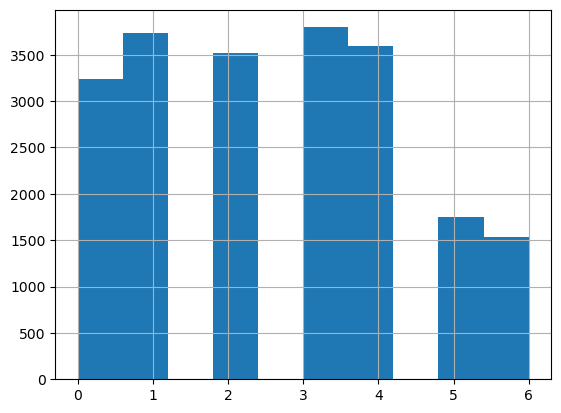

In [241]:
data['week_day'].hist();

На выходных объвления размещают реже, чем в будние дни.

12) month

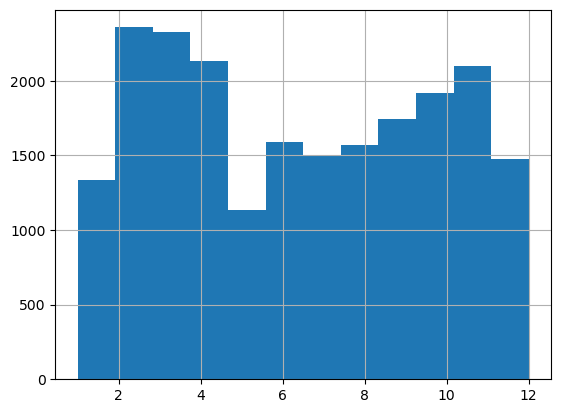

In [242]:
data['month'].hist(bins = 12);

В январе, мае и декабре реже всего публикуют объявления. Чаще всего в феврале. Все 3 месяца лета +- одинаково

**Как быстро продавались квартиры (столбец days_exposition)**

Гистограмма

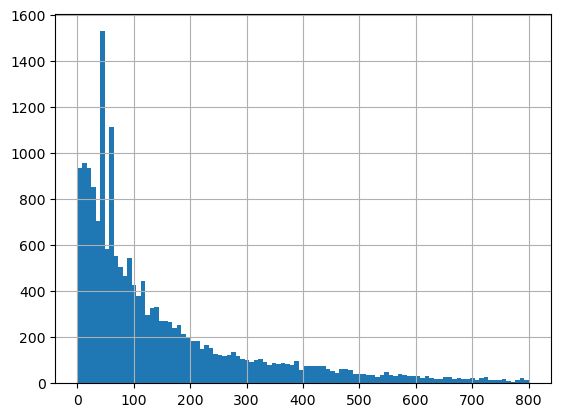

In [243]:
data['days_exposition'].hist(bins = 100, range = (1,800));

Посчитайте среднее и медиану.

In [244]:
data['days_exposition'].describe()

count    18620.000000
mean       171.005854
std        209.332752
min          1.000000
25%         43.000000
50%         90.000000
75%        216.000000
max       1580.000000
Name: days_exposition, dtype: float64

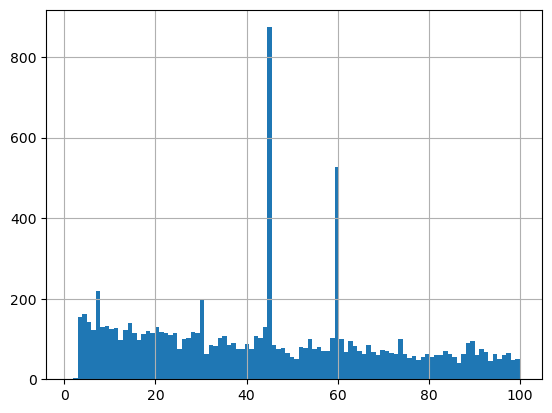

In [245]:
data['days_exposition'].hist(bins = 100, range = (1,100));

Можно предположить, что в эти дни нужно было продливать объявления. Возможно продавец забывал это сделать, либо передумывал продавать квартиру

В большинстве случаев продажи занимают около трех месяцев. Кажется разумным, что продажа меньше 45 дней - быстрая, а больше 2 лет - долгая

**Определяем факторы, которые больше всего влияют на общую (полную) стоимость объекта**

- общая площадь;
- жилая площадь;
- площадь кухни;

In [246]:
data['last_price'].corr(data['total_area'])

0.6788280144548775

In [247]:
data['last_price'].corr(data['living_area'])

0.5162733378353804

In [248]:
data['last_price'].corr(data['kitchen_area'])

0.3521753590726112

total area ближе всего к цене. Округлим для чистоты данных

In [249]:
data['total_area'] = data['total_area'].round()

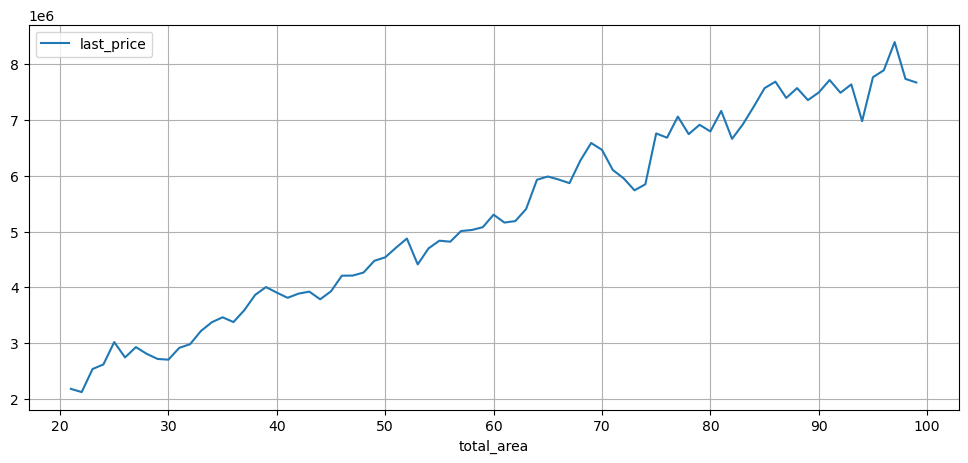

In [250]:
data.query('last_price < 10000000 & total_area > 20 & total_area < 100').pivot_table(index='total_area', values='last_price').plot(grid=True, figsize=(12, 5));

Больше площадь - больше стоимость

- количество комнат;

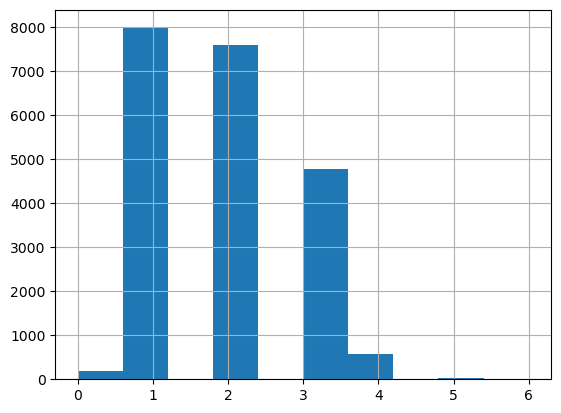

In [251]:
data['rooms'].hist(bins = 10, range = (0, 6));

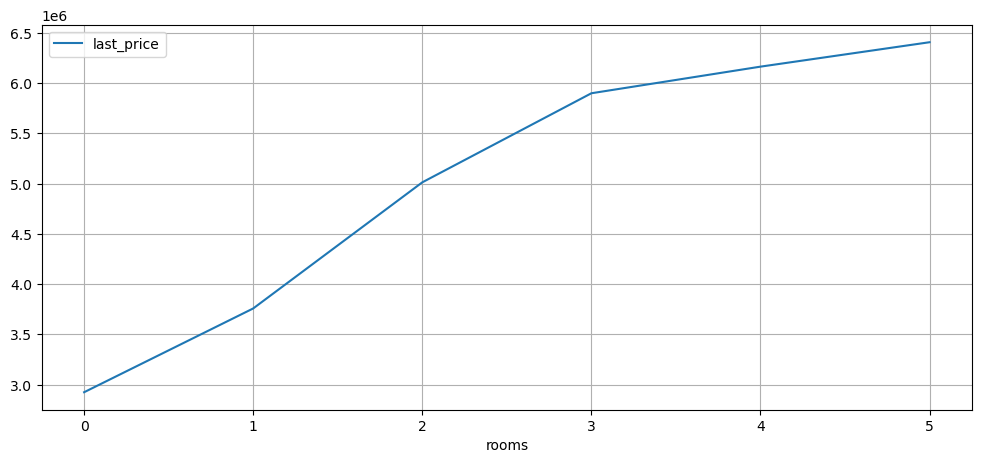

In [252]:
data.query('rooms < 6').pivot_table(index='rooms', values='last_price').plot(grid=True, figsize=(12, 5));

Чем больше комнат, тем дороже квартира

- высота потолков;

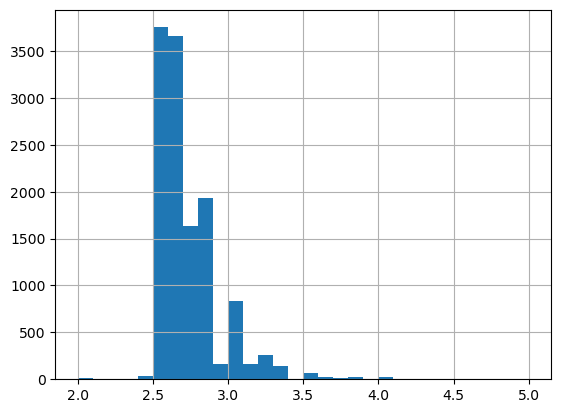

In [253]:
data['ceiling_height'].hist(bins = 30, range = (2, 5));

округлим до 1 десятой

In [254]:
data['ceiling_height'] = data['ceiling_height'].round(1)

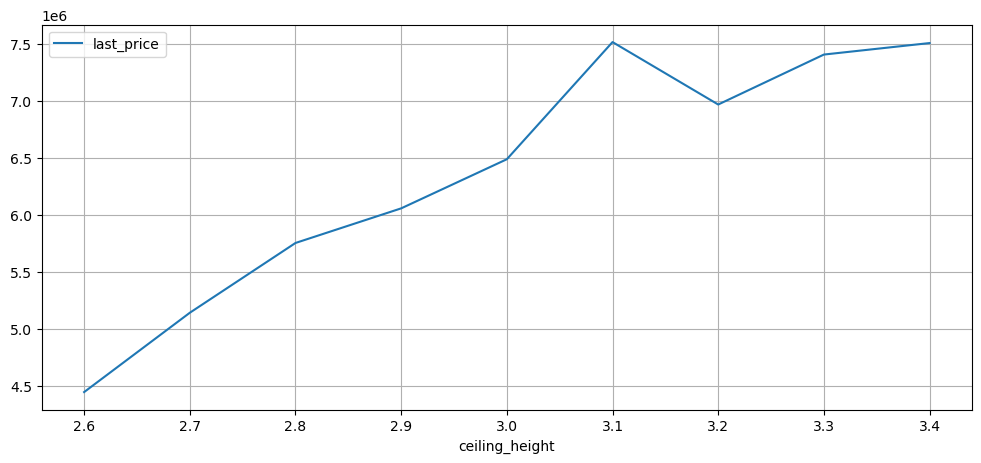

In [255]:
data.query('ceiling_height < 3.5 & ceiling_height > 2.5').pivot_table(index='ceiling_height', values='last_price').plot(grid=True, figsize=(12, 5));

Выше потолок - выше стоимость 

- этаж квартиры;

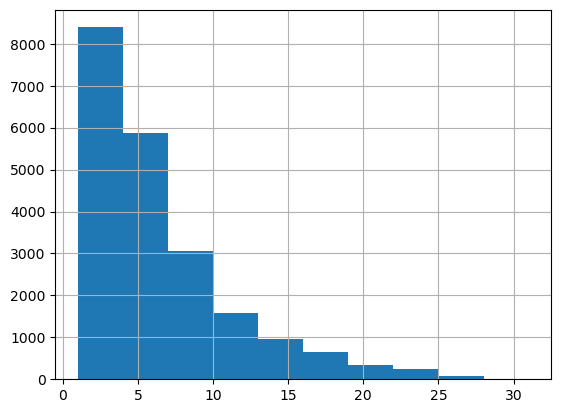

In [256]:
data['floor'].hist();

Прослеживается связь с первый этажом. В следующем задании проверим эту гипотезу.

- тип этажа квартиры («первый», «последний», «другой»);

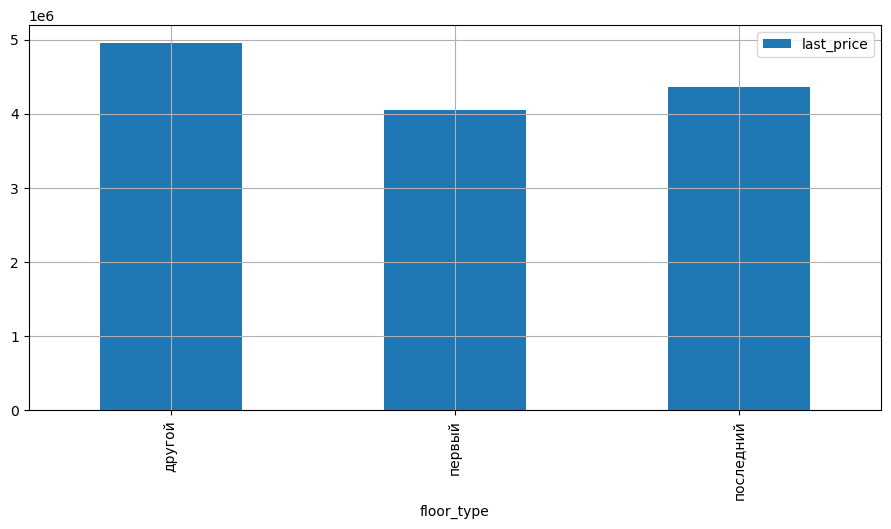

In [149]:
data.pivot_table(index='floor_type', values='last_price').plot(grid=True, figsize=(11, 5), kind = 'bar');

Квартиры на первом этаже стоят дешевле

 - общее количество этажей в доме;

In [ ]:
data['floors_total'].hist();

In [ ]:
data.query('floors_total < 30').pivot_table(index='floors_total', values='last_price').plot(grid=True, figsize=(11, 5), kind = 'bar');

В домах этажность 6-8 квартиры стоят дороже.

 - расстояние до центра города в метрах;

In [ ]:
data['cityCenters_nearest'].hist(bins = 20, range = (1,40000));

Посмотрим гистограмму в км

In [ ]:
data['cityCenters_nearest_km'].hist();

In [ ]:
data.query('cityCenters_nearest < 20000').pivot_table(index='cityCenters_nearest_km', values='last_price').plot(grid=True, figsize=(11, 5));

Ближе к центру - дороже квартира

 - расстояние до ближайшего аэропорта;

In [ ]:
data['airports_nearest'].hist();

In [ ]:
data.query('airports_nearest < 50000').pivot_table(index='airports_nearest', values='last_price').plot(grid=True, figsize=(11, 5))

Квартиры в отдаленности от аэропорта стоят дороже.

- расстояние до ближайшего парка;

In [ ]:
data['parks_nearest'].hist();

In [ ]:
data.query('parks_nearest < 600').pivot_table(index='parks_nearest', values='last_price').plot(grid=True, figsize=(11, 5));

Стоимость парка рядом не влияет на стоимость квартиры

- день и месяц публикации объявления

In [ ]:
data.pivot_table(index='week_day', values='last_price').plot(grid=True, figsize=(11, 5), kind = 'bar');

In [ ]:
data.pivot_table(index='month', values='last_price').plot(grid=True, figsize=(11, 5), kind = 'bar');

Какая-то связь не прослеживается

год публикации

In [ ]:
data.pivot_table(index='year', values='last_price').plot(grid=True, figsize=(11, 5), kind = 'bar');

Можно предположить, что в 2014 году квартиры стоили дороже.

**Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.**

In [151]:
median_price = data.pivot_table(index='locality_name', values='price_m2', aggfunc=['count','sum'])
median_price.columns = ['Всего объявлений','общая сумма']
median_price['Цена одного метра'] = median_price['общая сумма'] / median_price['Всего объявлений']
median_price = median_price.sort_values(by='Всего объявлений',ascending = False)
median_price.head(10)

,Всего объявлений,общая сумма,Цена одного метра
locality_name,,,
санкт-петербург,13390,1420318319,106073.063406
поселок мурино,556,47639058,85681.758993
поселок шушары,431,33957714,78788.199536
всеволожск,390,26166452,67093.466667
пушкин,333,33497836,100594.102102
колпино,332,25006979,75322.225904
поселок парголово,324,29320235,90494.552469
гатчина,300,20604149,68680.496667
деревня кудрово,297,27440708,92392.956229


Самые дорогие квартиры в Санкт-Петербурге. Самые дешевые в Выборге.

**Вычисляем среднюю цену каждого километра.**

In [152]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].fillna(0)
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].round().astype('int64')

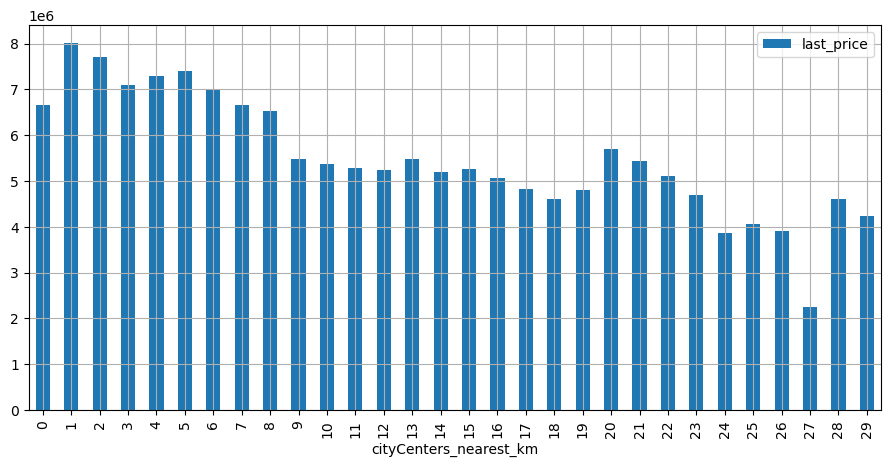

In [153]:
data.query('locality_name == "санкт-петербург"').pivot_table(index='cityCenters_nearest_km', values='last_price').plot(grid=True, figsize=(11, 5), kind = 'bar');

In [154]:
median_km = data.query('locality_name == "санкт-петербург"').pivot_table(index='cityCenters_nearest_km', values='last_price',aggfunc=['median'])
median_km

,median
,last_price
cityCenters_nearest_km,
0,6150000
1,8200000
2,7775000
3,6965000
4,7100000
5,7203654
6,6737800
7,6300000


Чем квартира ближе к центру от 8го километра, тем она дороже. Далее расстояние играет не такую большую роль.

### Общий вывод


<br>В этом проекте я исследовал архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Архив изначально содержал ряд проблем в данных, таких как: неверный тип данных, неявные дубликаты в названиях населенных пунктов, пропуски и аномальные значения, которые могут отразиться на общей структуре исследования. После предобработки данных были устранены все возможные проблемы, а также удалены выбросы в данных, которые составили примерно 10% от изначального объема объявлений. Для точности исследования были посчитаны и добавлены в таблицу новые данные:
 
<br>-цена одного квадратного метра
<br>-день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
<br>-месяц публикации объявления
<br>-год публикации объявления
<br>-тип этажа квартиры (значения — «первый», «последний», «другой»)
<br>-расстояние в км до центра города

<br>Далее был проведен анализ данных, для каждого параметра была построена гистограмма и описан промежуточный вывод. Основные тезисы этой работы:
    
<br>-Больше всего объявлений в диапозоне от 2 до 6 миллионов
<br>-Больше всего объявлений о продаже однокомнатных и двухкомнатных квартир
<br>-В большинстве объявлений высота потолка варьируется в диапозоне от 2.5 до 3 м.
<br>-Чаще всего продают квартиры на этажах с 1 по 5
<br>-Последний этаж продается также часто, как и первый
<br>-В 5ти этажных и 9ти этажных домах квартиры продаются чаще всего
<br>-Больше всего объявлений на расстоянии 10 - 18 км. от центра
<br>-Расстояние до аэропорта в среднем составляет 28 км
<br>-Для большинства объявлений парк находится в километровой доступности
<br>-На выходных объвления размещают реже, чем в будние дни
<br>-В январе, мае и декабре реже всего публикуют объявления. Чаще всего в феврале. Все 3 месяца лета +- одинаково</li>
<br>-В большинстве случаев продажи занимают около трех месяцев. Кажется разумным, что продажа меньше 45 дней - быстрая, а больше 2 лет - долгая

<br>Были определены факторы больше всего влияющие на общую (полную) стоимость объекта. Изучены зависимость цена объекта от: общей площади, жилой площади, площади кухни, количества комнат, этажа, на котором расположена квартира (первый, последний, другой), даты размещения (день недели, месяц, год). На основании полученной информации были сделаны следующие выводы:

<br>-Больше площадь - больше стоимость объекта
<br>-Чем больше комнат, тем дороже квартира
<br>-Выше потолок - выше стоимость
<br>-Квартиры на первом этаже стоят дешевле
<br>-В домах этажность 6-8 квартиры стоят дороже.
<br>-Расположение ближе к центру города - стоимость объкта выше.
<br>-Квартиры в отдаленности от аэропорта стоят дороже.
<br>-в 2014 году квартиры стоили дороже.
<br>-Наличие парка рядом,день и месяц публикации объявления не влияют на стоимость квартиры.
<br>-Самые дорогие квартиры в Санкт-Петербурге. Самые дешевые в Выборге.
<br>-Чем квартира ближе к центру от 8го километра, тем она дороже. Далее расстояние играет не такую большую роль. 
       